## Netflix Recommender Engine using SVD

#### Problem Statement
Customer Behaviour and it’s prediction lies at the core of every Business Model. From Stock Exchange, e-Commerce and Automobile to even Presidential Elections, predictions serve a great purpose. Most of these predictions are based on the data available about a person’s activity either online or in-person.

Recommendation Engines are the much needed manifestations of the desired Predictability of User Activity. Recommendation Engines move one step further and not only give information but put forth strategies to further increase users interaction with the platform.

In today’s world OTT platform and Streaming Services have taken up a big chunk in the Retail and Entertainment industry. Organizations like Netflix, Amazon etc. analyse User Activity Pattern’s and suggest products that better suit the user needs and choices.

For the purpose of this Project we will be creating one such Recommendation Engine from the ground-up, where every single user, based on there area of interest and ratings, would be recommended a list of movies that are best suited for them.

#### Objective
1. Find out the list of most popular and liked genre
2. Create Model that finds the best suited Movie for one user in every genre.
3. Find what Genre Movies have received the best and worst ratings based on User Rating.


In [42]:
# Installing the library for matrix factorization functions
# !conda install -c conda-forge scikit-surprise

##### Importing Libraries and Reading Data

In [43]:
# Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from surprise import Dataset, Reader
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise import accuracy

from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [44]:
# Reading the dataset
df = pd.read_csv("CapstoneDataSet.csv")
df.head()

,Cust_Id,Rating,Movie_Id,Genre,MovieName
0,1488844,3,1,Action,Dinosaur Planet
1,822109,5,1,Action,Dinosaur Planet
2,885013,4,1,Action,Dinosaur Planet
3,30878,4,1,Action,Dinosaur Planet
4,823519,3,1,Action,Dinosaur Planet


In [45]:
# Inspecting the dataset
print(df.shape)
df.info()

(1048574, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048574 entries, 0 to 1048573
Data columns (total 5 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Cust_Id    1048574 non-null  int64 
 1   Rating     1048574 non-null  int64 
 2   Movie_Id   1048574 non-null  int64 
 3   Genre      1047488 non-null  object
 4   MovieName  1048574 non-null  object
dtypes: int64(3), object(2)
memory usage: 40.0+ MB


##### Data Understanding

[]

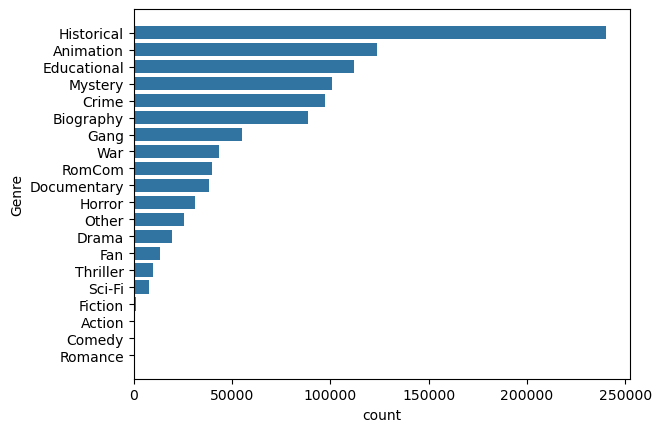

In [46]:
# Movie Genre Distribution
sns.countplot(df['Genre'], order = df['Genre'].value_counts().index)
plt.plot()

We see that the top 3 most popular genres are Historical, Animation and Educational.

Next, let's look at the most rated movie genres

[]

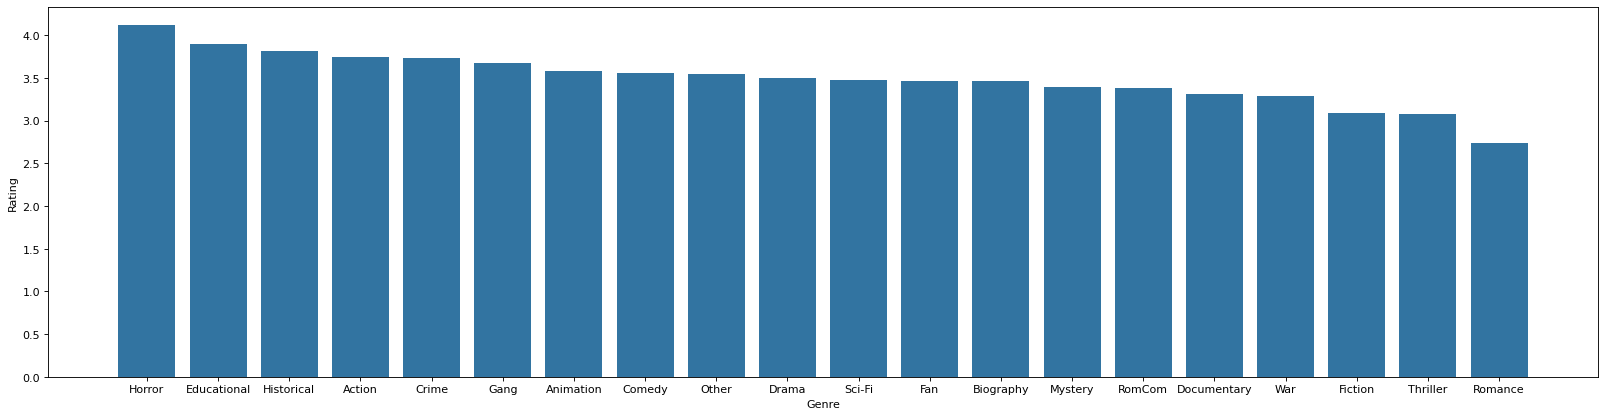

In [47]:
plt.figure(figsize=(25, 6), dpi=80)
sns.barplot(df.groupby('Genre')['Rating'].mean().sort_values(ascending=False))

plt.plot()

We see that the top 3 most highly rated genres are Horror, Educational and Historical. The 3 least rated genres are Romance, Thriller and Fiction.

##### Data Preparation

Missing Value Treatment

In [48]:
# Check for column-wise missing values
df.isnull().sum()/df.shape[0]

Cust_Id      0.000000
Rating       0.000000
Movie_Id     0.000000
Genre        0.001036
MovieName    0.000000
dtype: float64

In [49]:
# Since the missing values in the Genre column are so less, we choose to just drop these rows
df = df.loc[~df['Genre'].isnull(),:].reset_index(drop=True)


In order to get the data ready for collaborative filtering, we need to change the structure of the dataset.

In [50]:
# Instantiate the encoder classes
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()
mlb = MultiLabelBinarizer()

# Implement encoding on the columns
df['Cust_Id_Enc'] = user_encoder.fit_transform(df['Cust_Id'])
df['Movie_Id_Enc'] = movie_encoder.fit_transform(df['Movie_Id'])

df = df.join(pd.DataFrame(mlb.fit_transform(df['Genre'].str.split(',')), columns=mlb.classes_, index=df.index))

df.head()

,Cust_Id,Rating,Movie_Id,Genre,MovieName,Cust_Id_Enc,Movie_Id_Enc,Action,Animation,Biography,...,Gang,Historical,Horror,Mystery,Other,RomCom,Romance,Sci-Fi,Thriller,War
0,1488844,3,1,Action,Dinosaur Planet,161739,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,822109,5,1,Action,Dinosaur Planet,89486,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,885013,4,1,Action,Dinosaur Planet,96231,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,30878,4,1,Action,Dinosaur Planet,3264,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,823519,3,1,Action,Dinosaur Planet,89631,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# # Select the columns needed
# df = df.drop(columns = ['Cust_Id','Movie_Id','Genre','MovieName'])
# df.head()

In [52]:
df.columns

Index(['Cust_Id', 'Rating', 'Movie_Id', 'Genre', 'MovieName', 'Cust_Id_Enc',
       'Movie_Id_Enc', 'Action', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Educational', 'Fan', 'Fiction', 'Gang',
       'Historical', 'Horror', 'Mystery', 'Other', 'RomCom', 'Romance',
       'Sci-Fi', 'Thriller', 'War'],
      dtype='object')

In [53]:
# Taking a sample of the code to reduce the size for model building
df = df.sample(10000)

Performing the train-test split

In [54]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=99)

In [55]:
print(train_df.shape)
print(test_df.shape)


(8000, 27)
(2000, 27)


##### Model Building

In [56]:
# Provide the rating scale to the model
reader = Reader(rating_scale=(1,5))

# creating the train set that is passed to the model
data = Dataset.load_from_df(train_df[['Cust_Id_Enc','Movie_Id_Enc','Rating']], reader)
trainset = data.build_full_trainset()

# creating the test set that will be used for evaluation
testset = trainset.build_anti_testset()


In [57]:
# Now having created the trainset, we pass this to the model
model_svd = SVD()
model_svd.fit(trainset)

In [58]:
# Generating predictions on test set
predictions_svd = model_svd.test(testset)
predictions_svd

[Prediction(uid=286541, iid=147, r_ui=3.628125, est=3.3617667229306676, details={'was_impossible': False}),
 Prediction(uid=286541, iid=155, r_ui=3.628125, est=3.498572289332513, details={'was_impossible': False}),
 Prediction(uid=286541, iid=207, r_ui=3.628125, est=3.22544798048194, details={'was_impossible': False}),
 Prediction(uid=286541, iid=76, r_ui=3.628125, est=2.8007651633799884, details={'was_impossible': False}),
 Prediction(uid=286541, iid=215, r_ui=3.628125, est=2.99596278501734, details={'was_impossible': False}),
 Prediction(uid=286541, iid=47, r_ui=3.628125, est=3.5166813580225, details={'was_impossible': False}),
 Prediction(uid=286541, iid=29, r_ui=3.628125, est=3.814128944794866, details={'was_impossible': False}),
 Prediction(uid=286541, iid=230, r_ui=3.628125, est=3.2096723631075412, details={'was_impossible': False}),
 Prediction(uid=286541, iid=196, r_ui=3.628125, est=3.3741350636462593, details={'was_impossible': False}),
 Prediction(uid=286541, iid=190, r_ui=3.

In [59]:
# Evaluating test set
accuracy.rmse(predictions_svd)

RMSE: 0.3433


0.3433065611823703

##### Generate Recommendations

In [66]:
# Creating movies id-name lookup
movie_lu = df[['Movie_Id','MovieName']].drop_duplicates().reset_index(drop=True)

# Function to get recommendations
def get_top_recos(user_id, n):
    user_movies = df.loc[df['Cust_Id']==user_id,'Movie_Id'].unique()
    all_movies = df['Movie_Id'].unique()
    movies_to_predict = list(set(all_movies) - set(user_movies)) # Remove list of movies already rated by user from universe

    user_movie_pairs = [(user_id, movie_id, 0) for movie_id in movies_to_predict] # create all possible combinations of the user with all movies
    predictions_cf = model_svd.test(user_movie_pairs) # Score the data to get predicted ratings for every movie

    top_n_recos = sorted(predictions_cf, key=lambda x: x.est, reverse=True)[:n] 

    top_n_movie_ids = [int(pred.iid) for pred in top_n_recos] # Fetch the movie id from prediction and save in a list
    top_n_movies = movie_encoder.inverse_transform(top_n_movie_ids) # Fetch the inverse transformed movie id
    top_n_movie_names = movie_lu[movie_lu['Movie_Id'].isin(top_n_movies)]['MovieName'].to_list()

    return top_n_movie_names

In [73]:
user_id = 192365
n = 5

recommendations = get_top_recos(user_id, n)

print(f"Top {n} predictions for User {user_id} are:")
for i, movie in enumerate(recommendations):
    print(f"{i+1}. {movie}")



Top 5 predictions for User 192365 are:
1. North by NorthWest
2. Chappelle's Show: Season 1
3. Aqua Teen Hunger Force: Vol. 1
4. Invader Zim
5. Viva La Bam: Season 1


#### Answering the objective questions
1. Find out the list of most popular and liked genre

`The top 3 most popular genres are Historical, Animation and Educational.`

2. Create Model that finds the best suited Movie for one user in every genre.

`Model model_svd created above, predictions for a test user generated`

3. Find what Genre Movies have received the best and worst ratings based on User Rating.

`The top 3 most highly rated genres are Horror, Educational and Historical. The 3 least rated genres are Romance, Thriller and Fiction.`
